In [1]:
!pip install gdown
!pip install monai[all]==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 19.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.1/264.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 53.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 81.1 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 64.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 60.7 MB/s eta 

In [2]:
import os
import time
import random
import gdown
from glob import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from monai.config import print_config
from monai.transforms import (
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    Resized,
    LoadImaged,
    Orientationd,
    RandGaussianNoised,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    RandRotated,
    ToTensord,
    RandAffined,
    Activations,
    AsDiscrete,
    EnsureTyped,
    ScaleIntensityd
)

from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first
from monai.losses import DiceLoss, DiceFocalLoss
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import SwinUNETR, UNet, UNETR
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

import torch

# %env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512
is_cuda = torch.cuda.is_available()
device = "cuda" if(is_cuda) else "cpu"
if(is_cuda):
    torch.cuda.empty_cache()
print_config()

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.3
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 1.30.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## <span style="color:red">Note</span>

Download data from [drive](https://drive.google.com/file/d/1yU_MeDoMHnLg0vNAy4Hb7_liJBogWl_N/view?usp=share_link) link and save the data in `/data` folder.

Folder Structure

```txt
├── data
    ├── imageTr        
    ├── labelsTR     
    └── test      
```

In [ ]:
if(not os.path.exists("model"))
    raise "No model Saved"

In [4]:
ROOT_DATA_FOLDER=r"data"
IMAGE_FOLDER=r"imagesTr"
LABEL_FOLDER=r"labelsTr"
TEST_FOLDER=r"test"
ROOT_MODEL_DIR=r"model"

In [5]:
image_path = sorted(glob(os.path.join(ROOT_DATA_FOLDER, IMAGE_FOLDER, "*.nii.gz")))
label_path = sorted(glob(os.path.join(ROOT_DATA_FOLDER, LABEL_FOLDER, "*.nii.gz")))
test_path = sorted(glob(os.path.join(ROOT_DATA_FOLDER, TEST_FOLDER, "*.nii.gz")))

data_path = [{"image": image_name, "label": label_name} for image_name, label_name in zip(image_path, label_path)]
test_path = [{"image": image_name} for image_name in test_path]

print("Total Train Data: ", len(data_path))
print("Total Test Data: ", len(test_path))

Total Train Data:  84


In [6]:
val_path = data_path[:3]
val_path += data_path[len(data_path)-1:]
train_path = [i for i in data_path if i not in val_path]

In [7]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityd(keys=["image"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(
            keys=["image", "label"], 
            spatial_size=(128, 128, 64), 
            mode=('trilinear', 'nearest')
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),
        EnsureTyped(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear"),
        ),
        ScaleIntensityd(keys=["image"]),
        CropForegroundd(keys=["image"], source_key="image"),
        Resized(
            keys=["image"], 
            spatial_size=(128, 128, 64), 
            mode=('trilinear')
        ),
        ToTensord(keys=["image"]),
    ]
)

In [8]:
batch_size=1
worker=0

val_dataset = Dataset(data=val_path, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=worker)

test_dataset = Dataset(data=test_path, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=worker)

In [9]:
def load_model(path):
    data = torch.load(path, map_location=device)
    
    model_state = data['model']
    train_loss = data['train_loss']
    val_metric = data['val_metric']
    
    return (model_state, train_loss, val_metric)

In [10]:
unet_model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
    dropout=0.3,
).cuda(device)

unetr_model = UNETR(
    img_size=(128, 128, 64),
    in_channels=1,
    out_channels=2,
    dropout_rate=0.5
).to(device)

swinunetr_model = SwinUNETR(
    img_size=(128, 128, 64),
    in_channels=1,
    out_channels=2,
    drop_rate =0.3,
    attn_drop_rate=0.3,
    dropout_path_rate=0.3,
    feature_size=48,
).cuda(device)

In [11]:
unet_model_file = "" ## model name if saved
unet_path = os.path.join(ROOT_MODEL_DIR, unet_model_file)
model_state, train_loss_unet, val_metric_unet = load_model(unet_path)
unet_model.load_state_dict(model_state)

<All keys matched successfully>

In [12]:
unetr_model_file = "" ## model name if saved
unetr_path = os.path.join(ROOT_MODEL_DIR, unetr_model_file)

model_state, train_loss_unetr, val_metric_unetr = load_model(unetr_path)
unetr_model.load_state_dict(model_state)

<All keys matched successfully>

In [13]:
swinunetr_model_file = "" ## model name if saved
swinunetr_path = os.path.join(ROOT_MODEL_DIR, swinunetr_model_file)
model_state, train_loss_swin, val_metric_swin = load_model(swinunetr_path)
swinunetr_model.load_state_dict(model_state)

<All keys matched successfully>

## Unet Loss and Metric

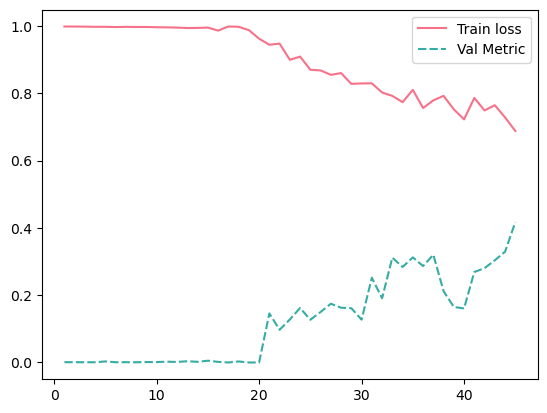

In [14]:
data = {
    "Train loss": train_loss_unet,
    "Val Metric": val_metric_unet
}
df = pd.DataFrame(data, index=range(1, len(train_loss_unet)+1))
sns.lineplot(data=df, palette="husl")
plt.show()

## UNETR Loss and Metric Graph

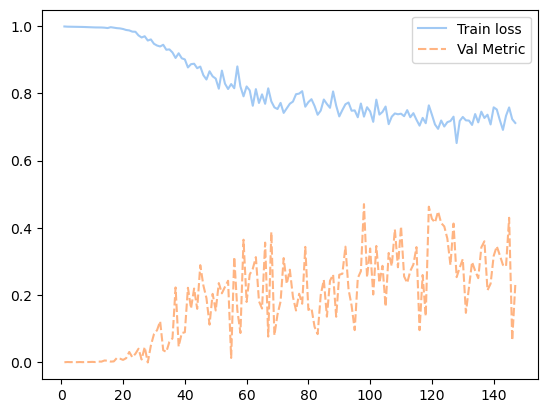

In [15]:
data = {
    "Train loss": train_loss_unetr,
    "Val Metric": val_metric_unetr
}
df = pd.DataFrame(data, index=range(1, len(train_loss_unetr)+1))
sns.lineplot(data=df, palette="pastel")
plt.show()

## Swin-UNETR Loss and Metric

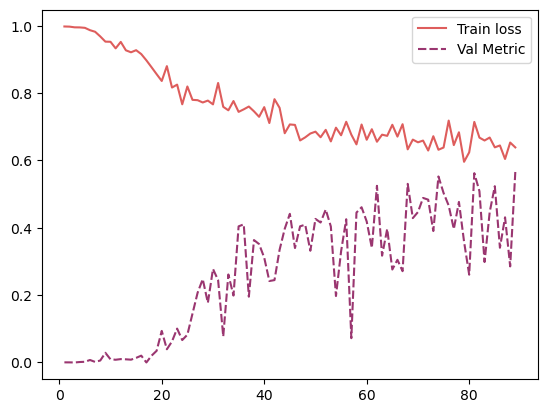

In [16]:
data = {
    "Train loss": train_loss_swin,
    "Val Metric": val_metric_swin
}
df = pd.DataFrame(data, index=range(1, len(train_loss_swin)+1))
sns.lineplot(data=df, palette="flare")
plt.show()

## Ensemble

In [43]:
metric_val = DiceMetric(include_background=False, reduction="mean")

In [17]:
post_pred = Compose([AsDiscrete(argmax = True, to_onehot = 2)])
post_label = Compose([AsDiscrete(to_onehot = 2)])

In [44]:
unet_model.cpu()
unetr_model.cpu()
swinunetr_model.cpu()

unet_model.eval()
unetr_model.eval()
swinunetr_model.eval()

unet_output_lst = []
unetr_output_lst = []
swinunetr_output_lst = []
val_label_lst = []

with torch.no_grad():
    for val_data in val_loader_without:
        val_input = val_data['image']
        
        val_labels = val_data['label']
        val_labels = post_label(val_labels[0, :, :, :])
        val_label_lst.append(val_labels)
        
        unet_output = unet_model(val_input)
        unet_output_lst.append(unet_output[0, :, :, :])
        
        unetr_output = unetr_model(val_input)
        unetr_output_lst.append(unetr_output[0, :, :, :])
        
        swinunetr_output = swinunetr_model(val_input)
        swinunetr_output_lst.append(swinunetr_output[0, :, :, :])
        
#     loss = 0
    for i in range(len(val_label_lst)):
        output = torch.stack([unet_output_lst[i], unetr_output_lst[i], swinunetr_output_lst[i]])
        output = torch.mean(output, dim=0)
        output = post_pred(output)
        print(output.size(), val_label_lst[i].size())
        metric_val(output, val_label_lst[i])
    
    metric = metric_val.aggregate().item()
    print(metric)

torch.Size([2, 128, 128, 64]) torch.Size([2, 128, 128, 64])
torch.Size([2, 128, 128, 64]) torch.Size([2, 128, 128, 64])
torch.Size([2, 128, 128, 64]) torch.Size([2, 128, 128, 64])
torch.Size([2, 128, 128, 64]) torch.Size([2, 128, 128, 64])
0.7254650592803955


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Output shape: torch.Size([128, 128, 64])


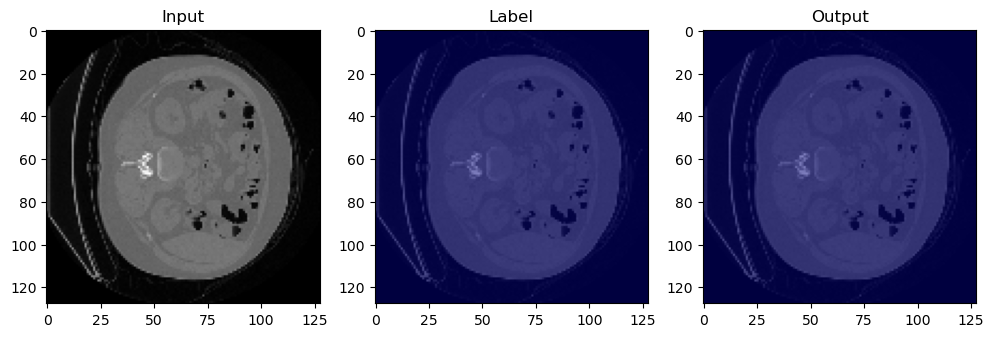

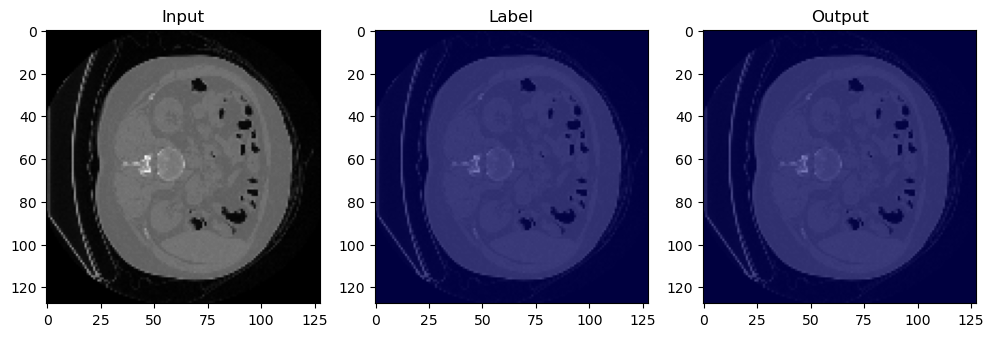

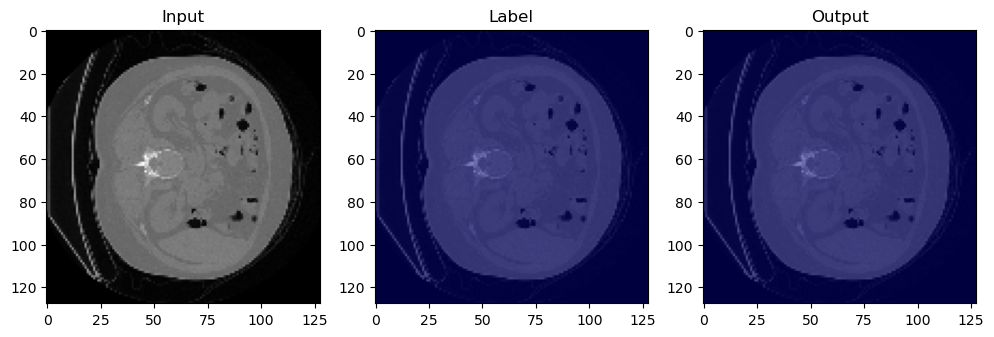

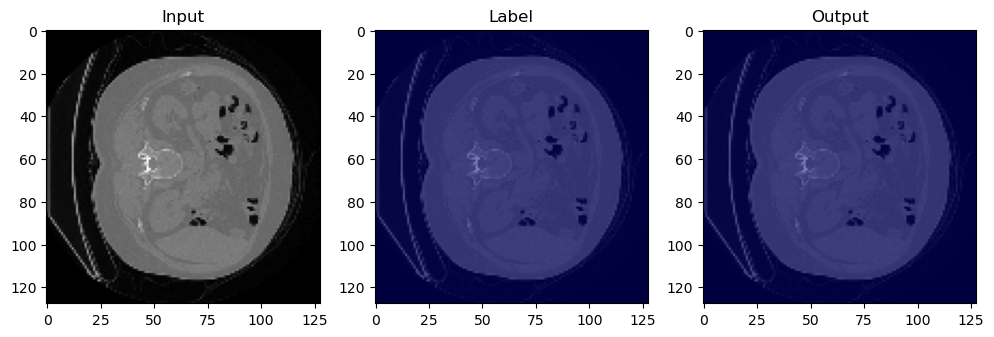

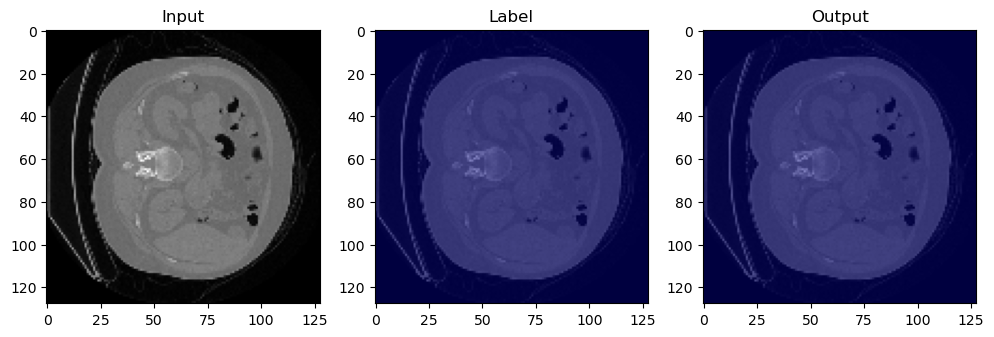

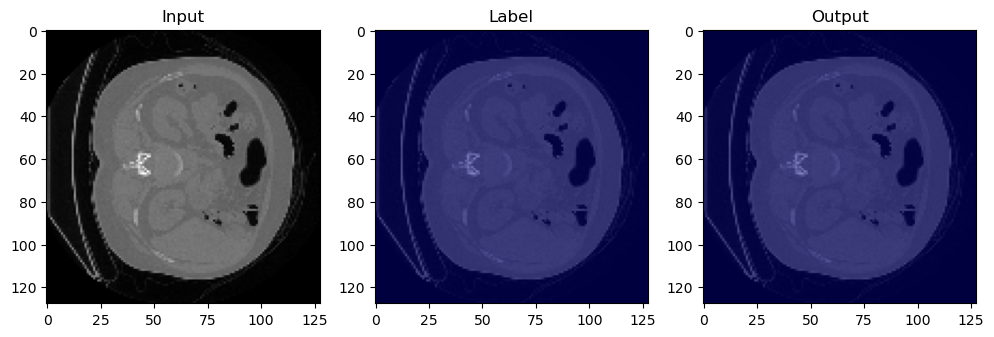

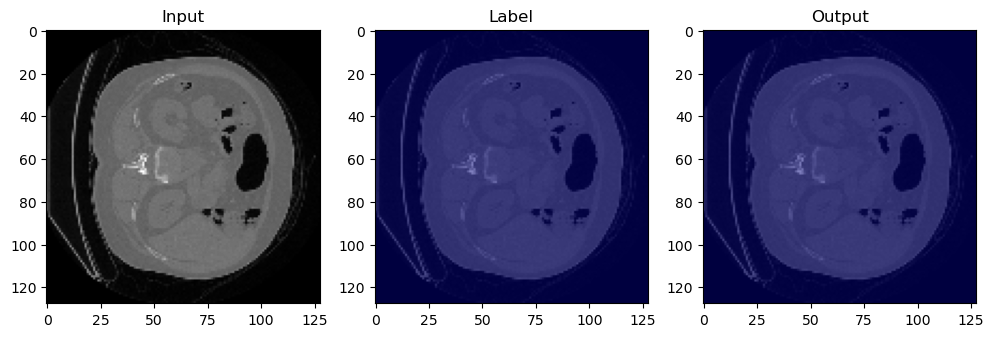

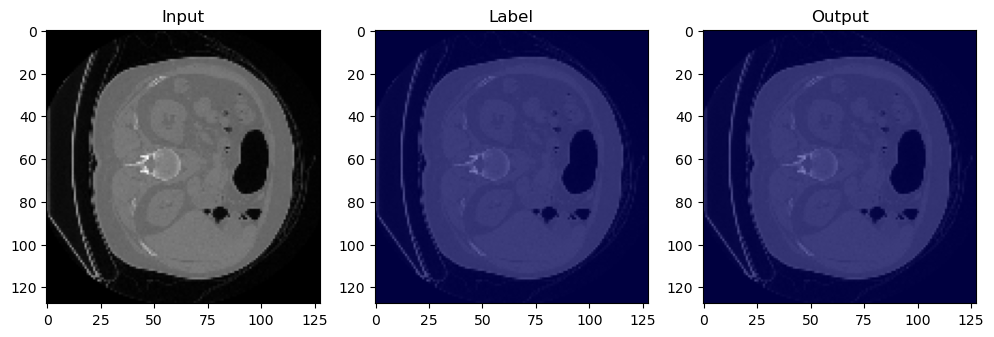

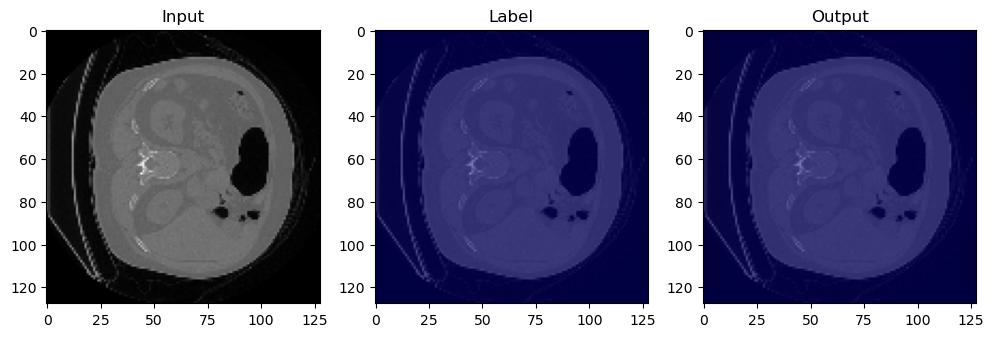

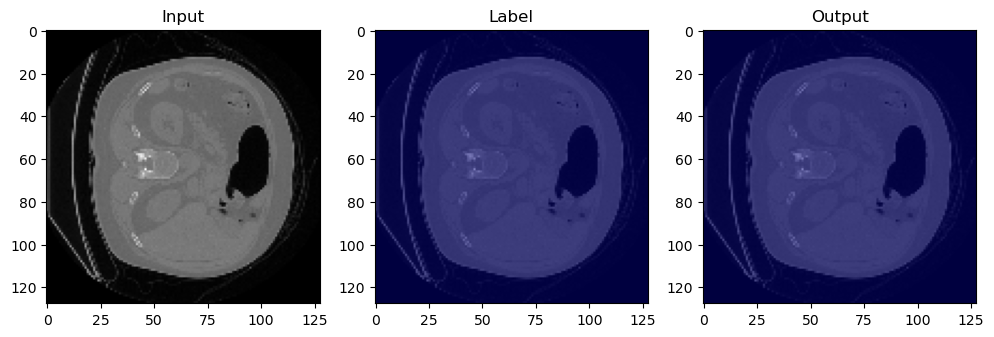

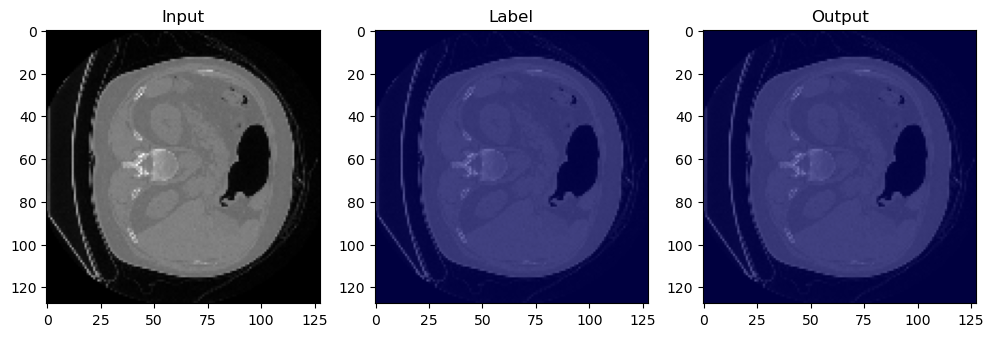

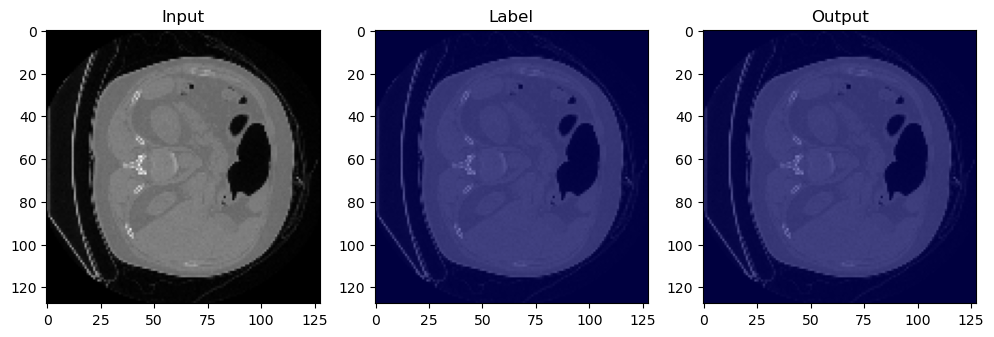

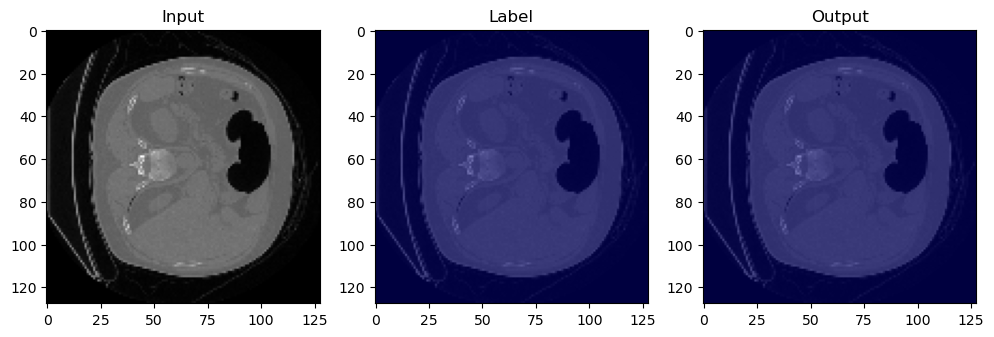

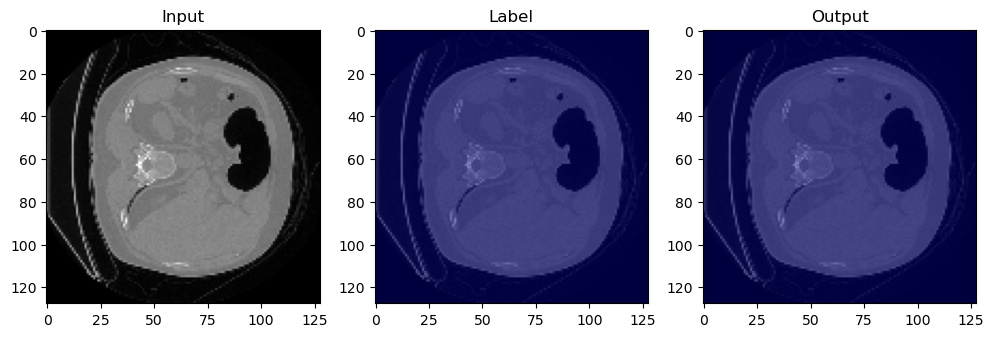

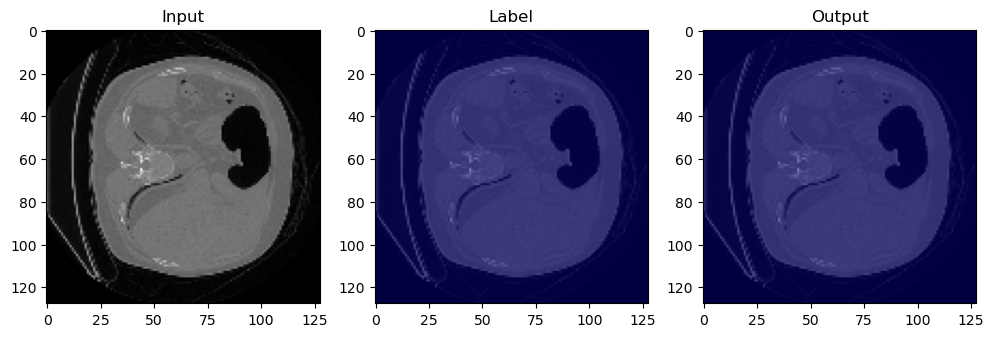

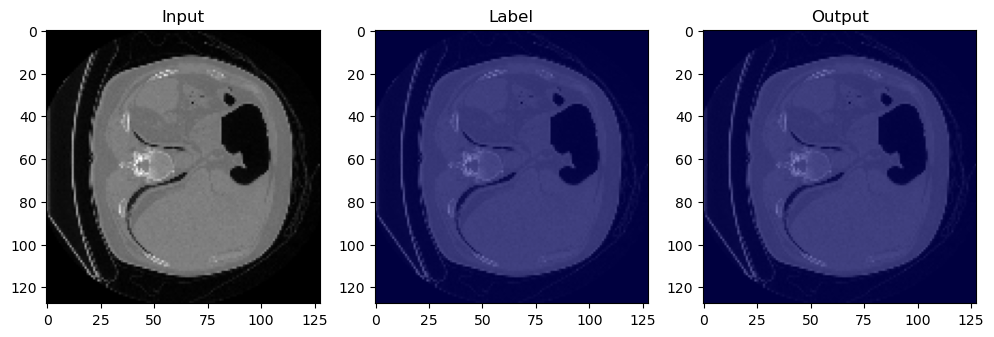

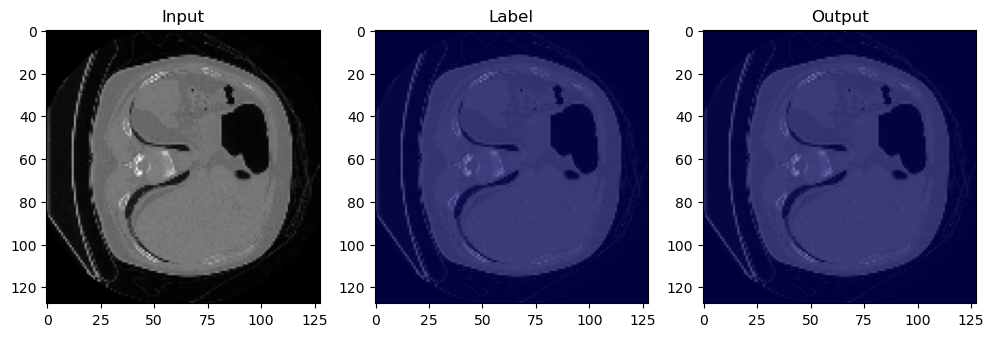

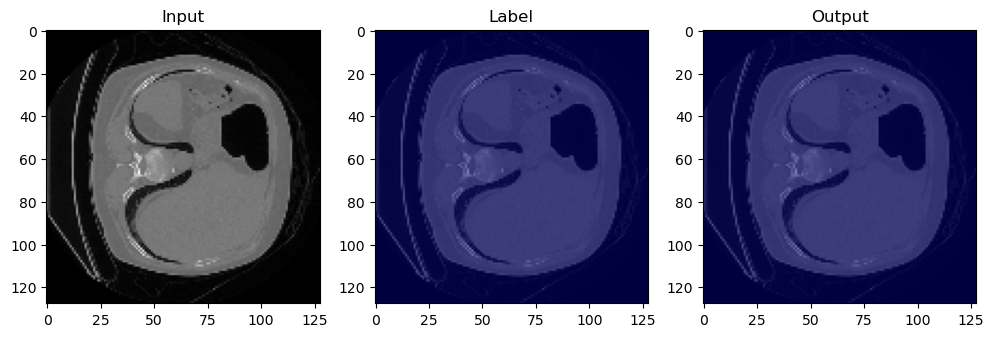

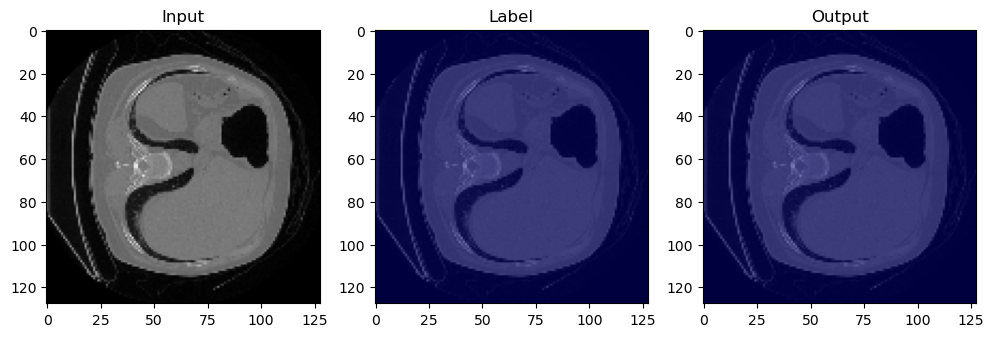

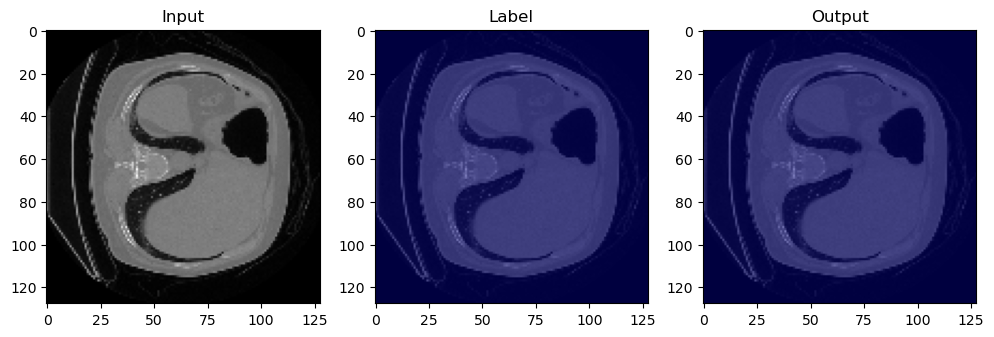

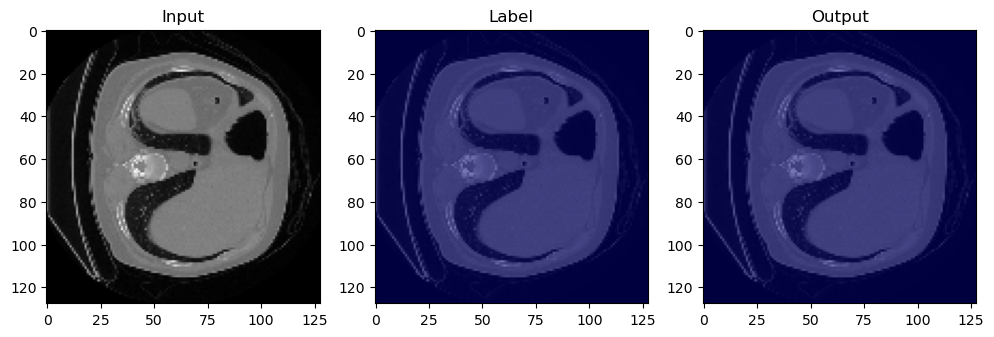

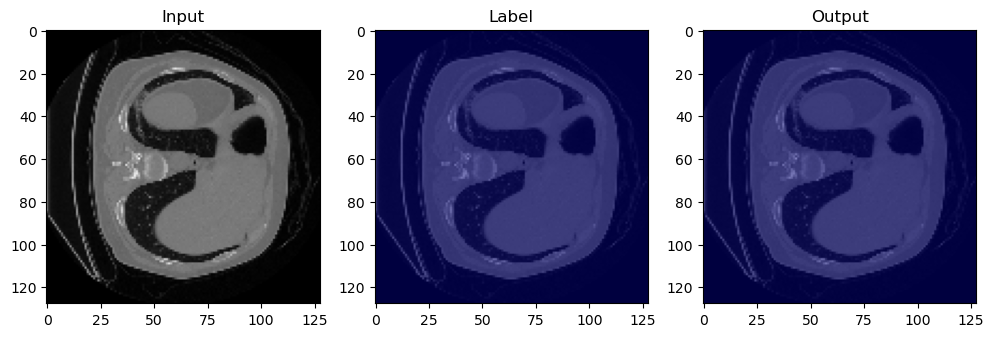

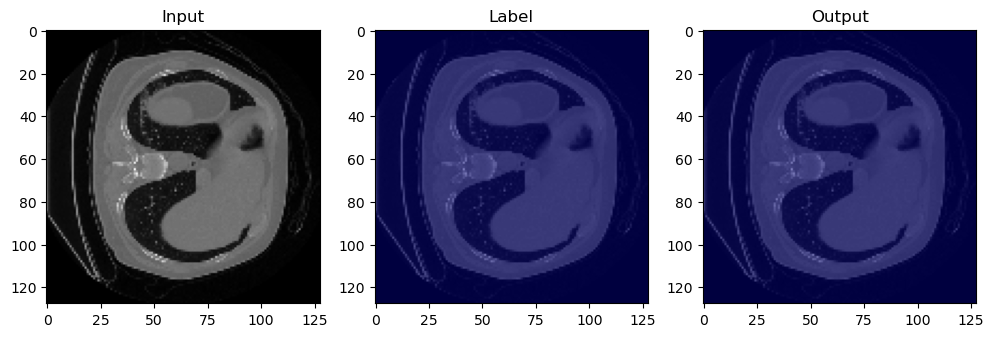

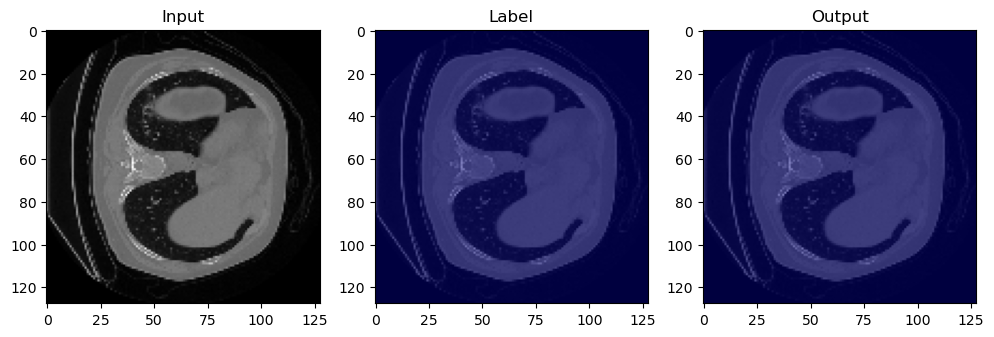

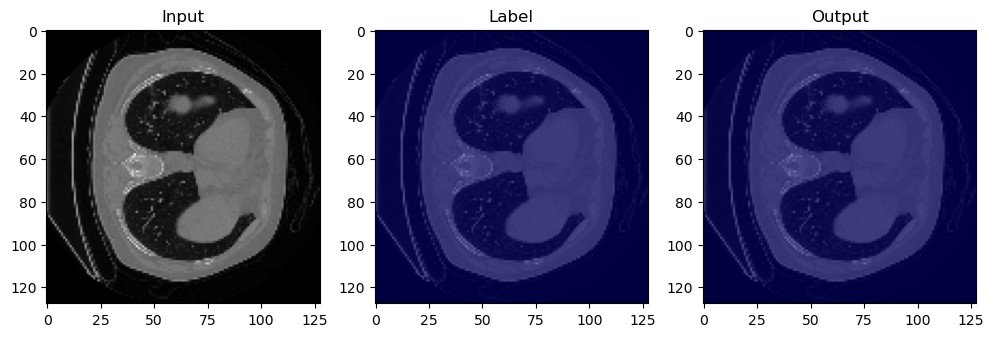

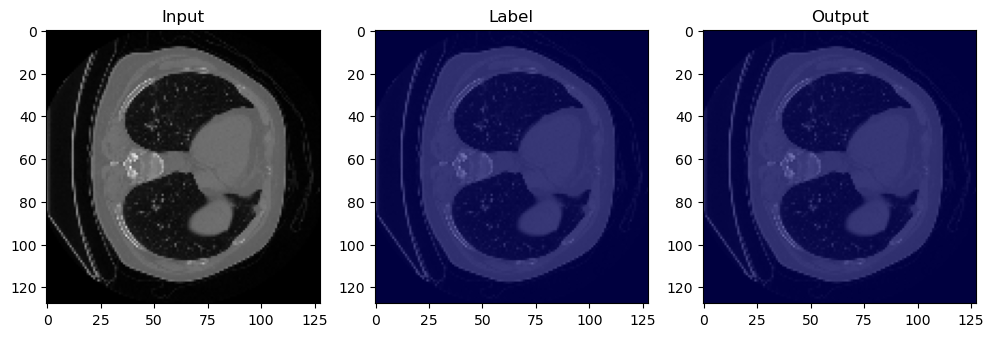

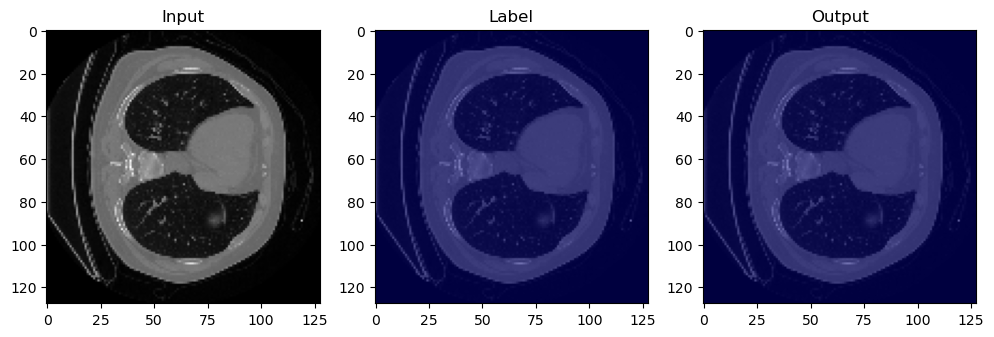

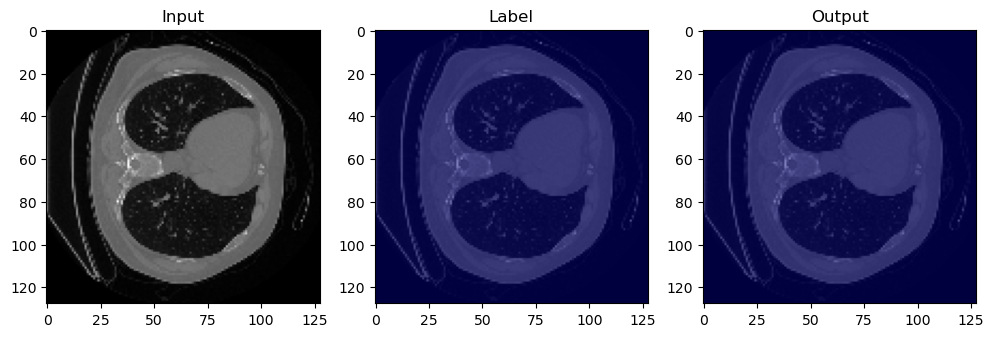

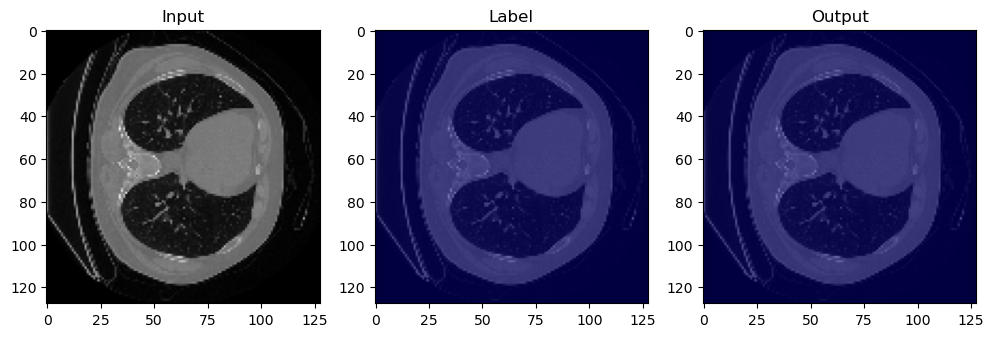

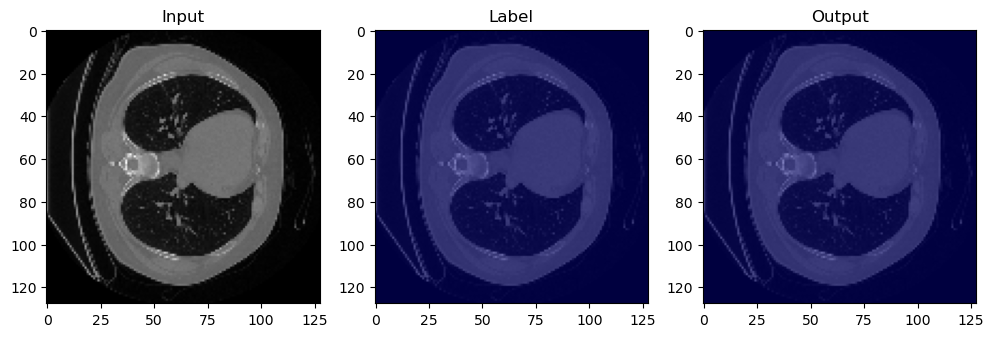

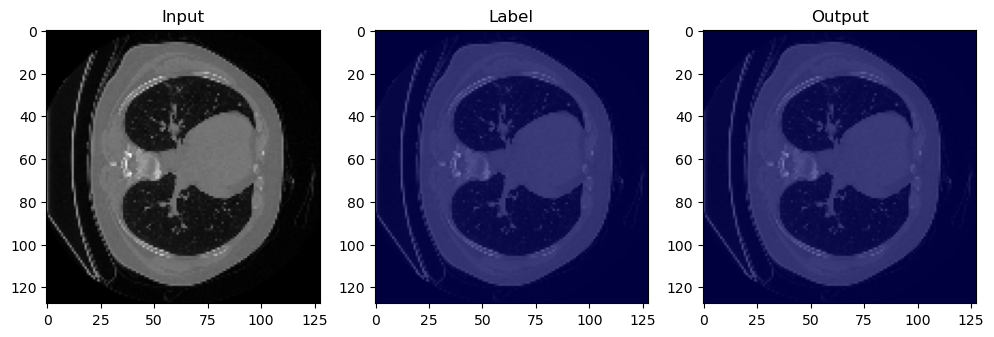

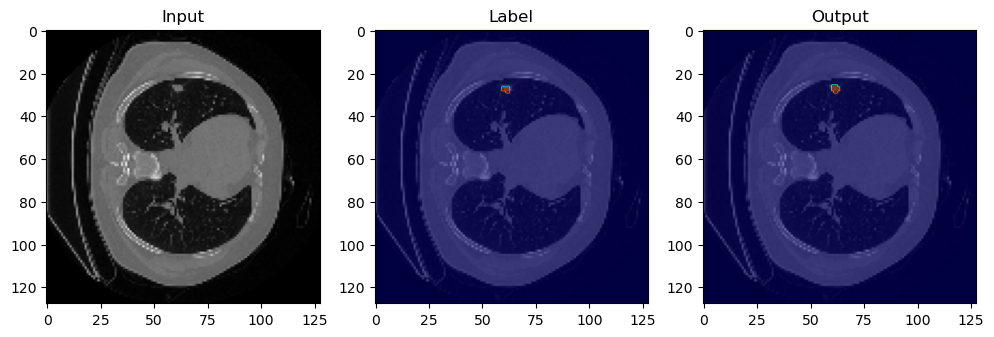

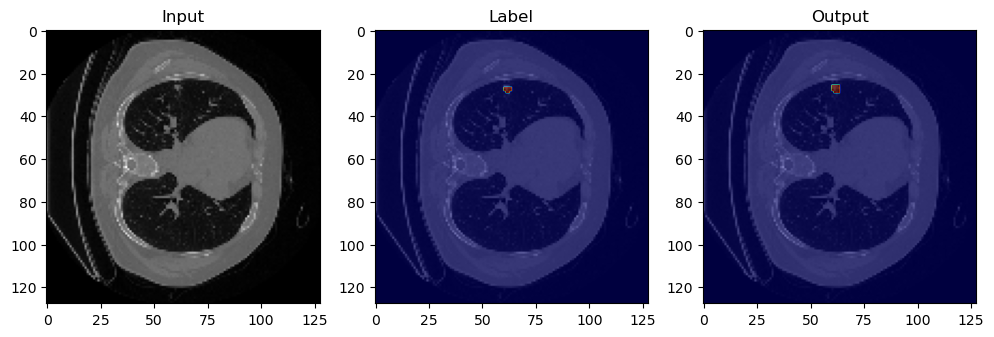

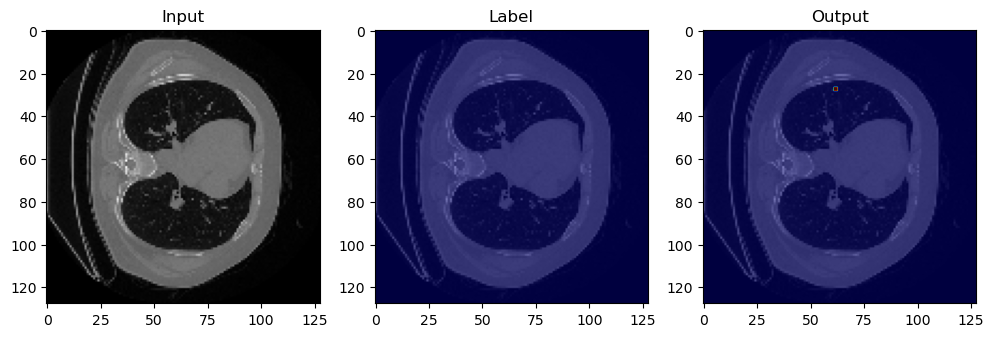

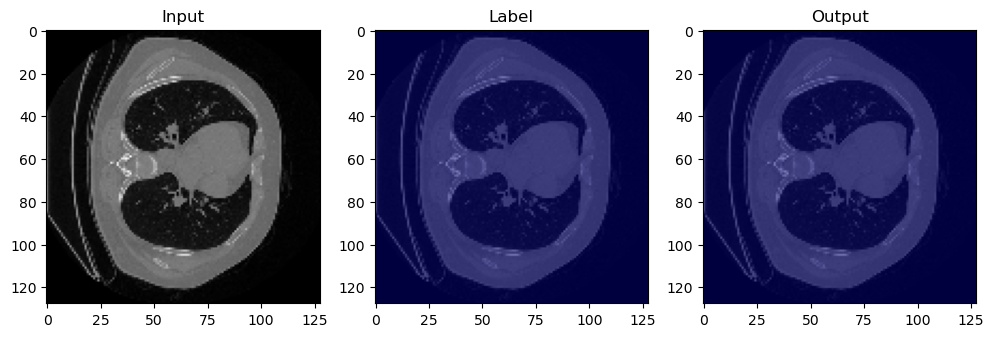

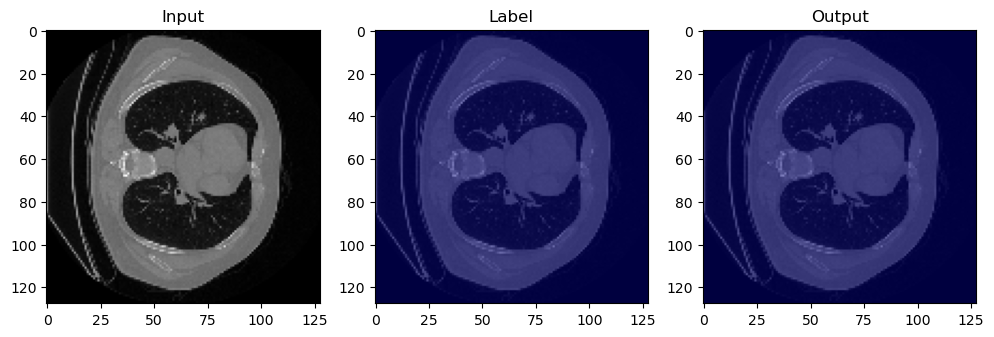

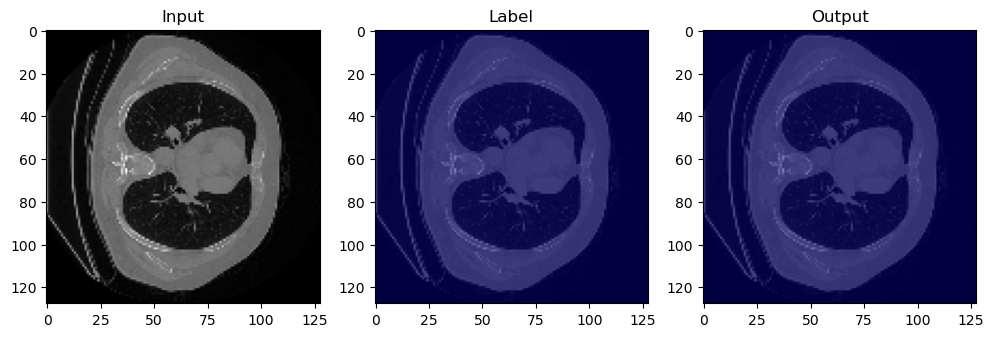

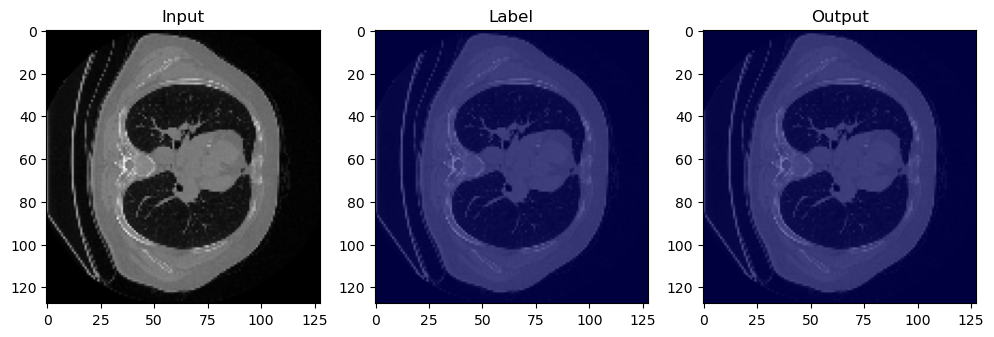

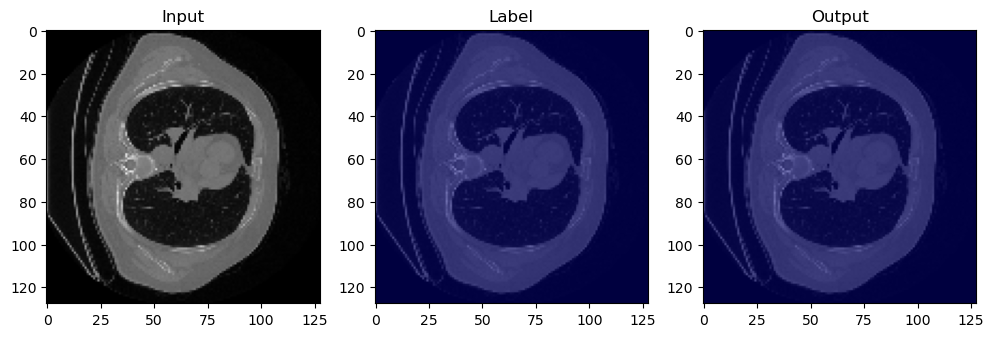

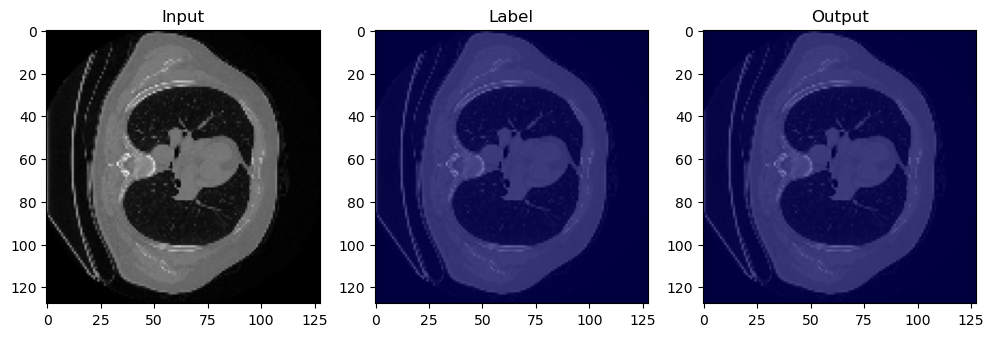

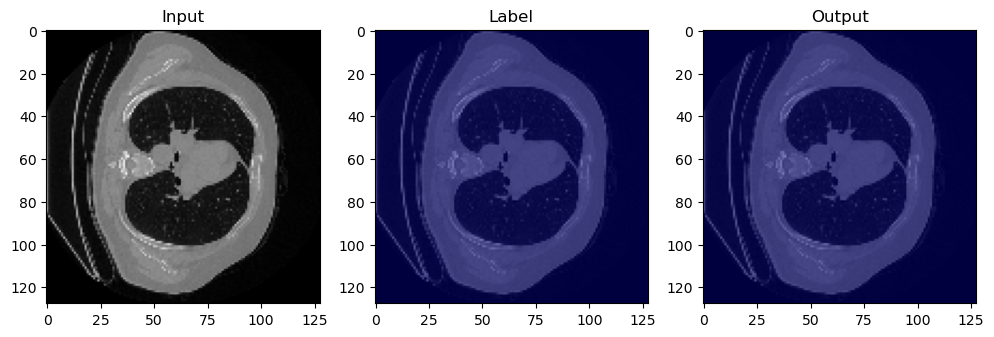

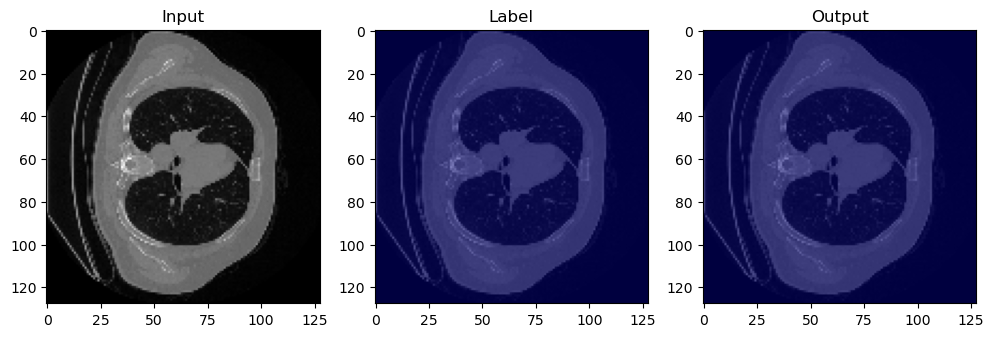

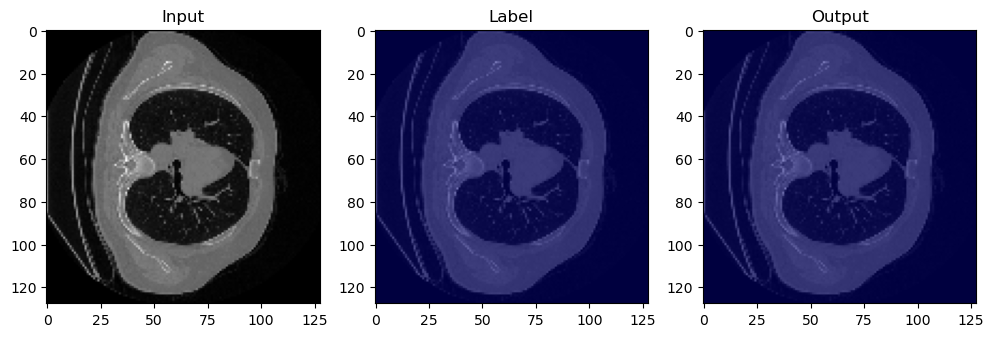

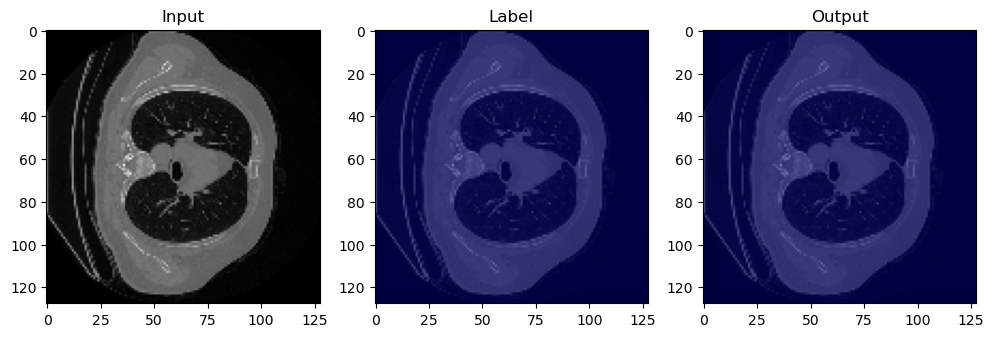

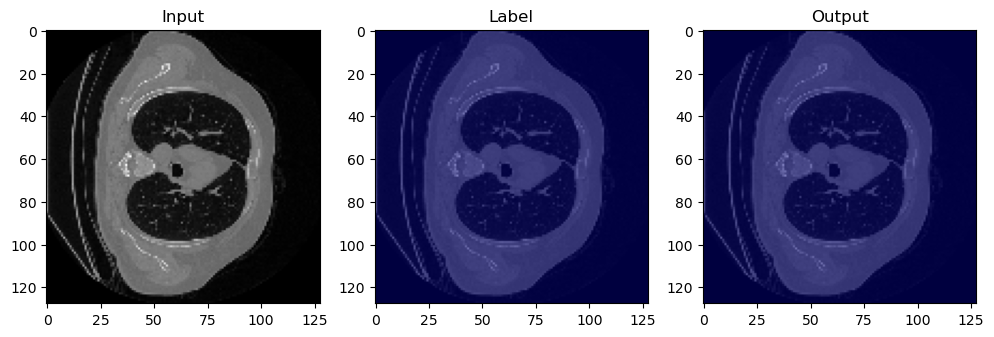

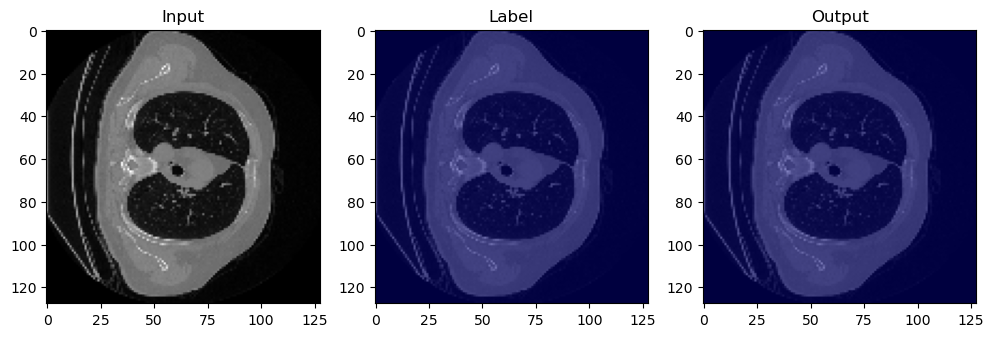

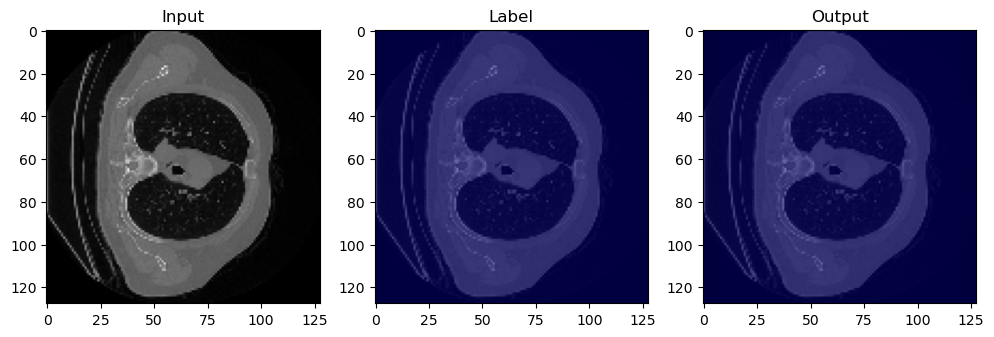

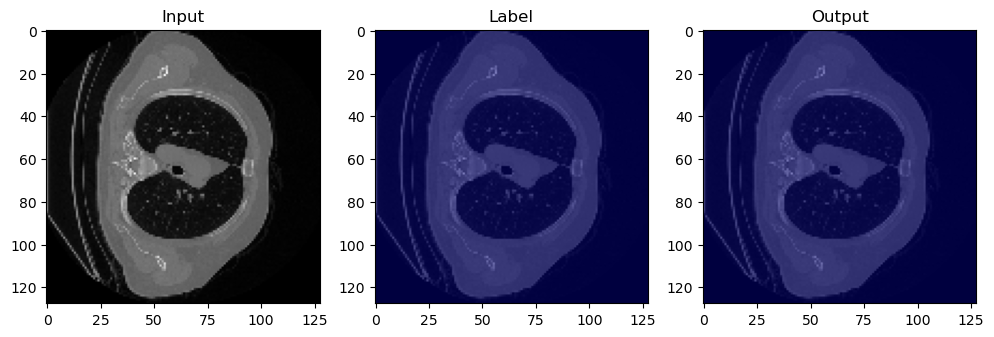

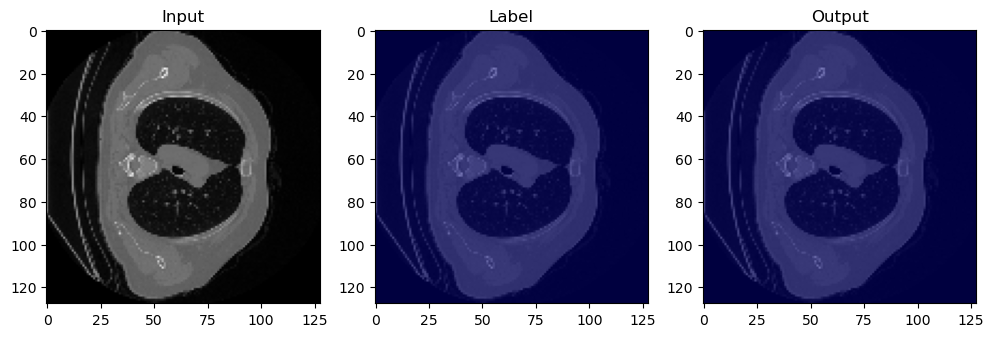

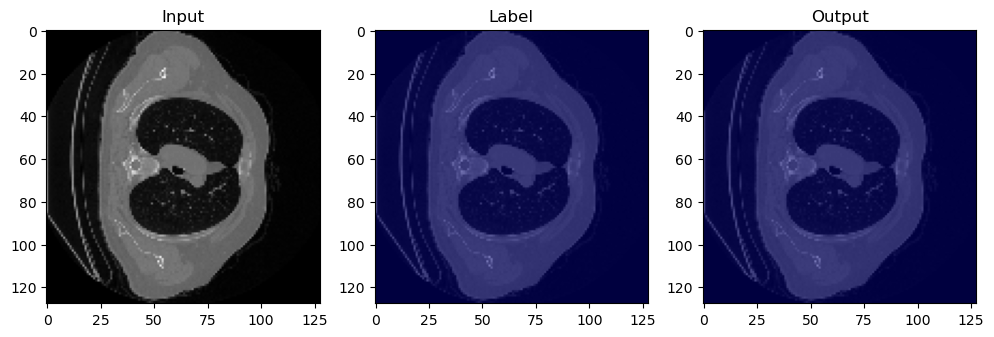

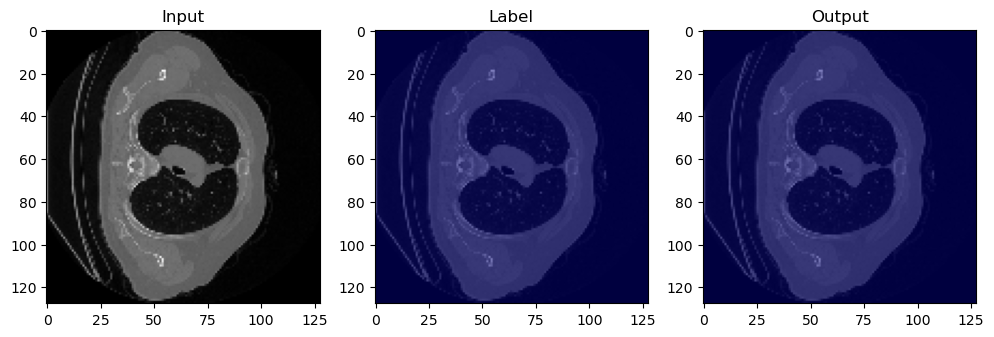

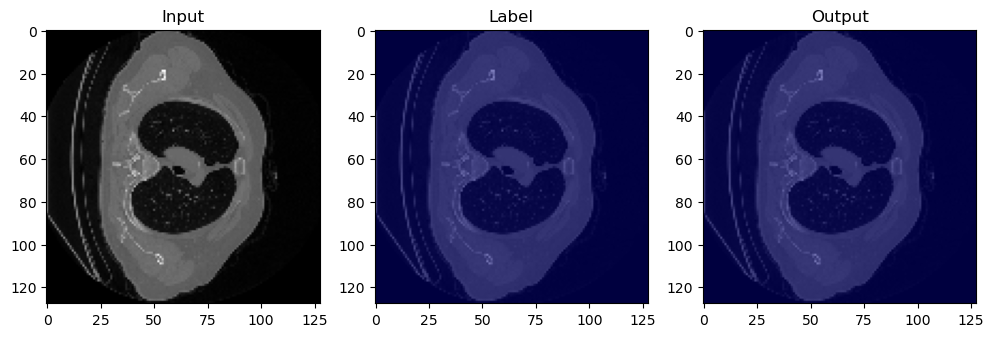

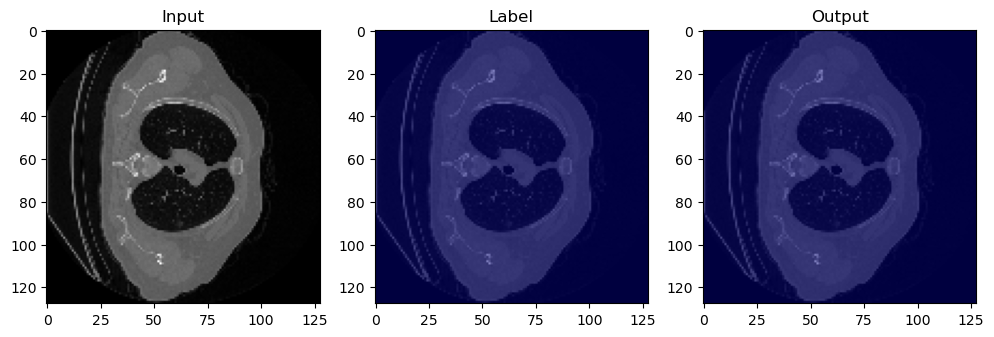

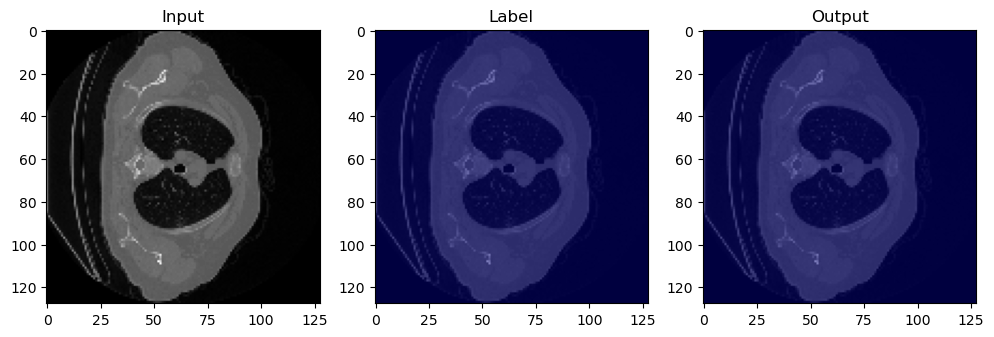

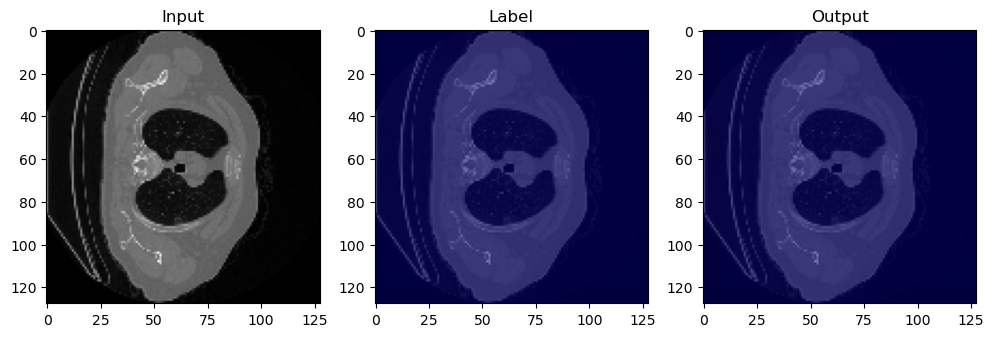

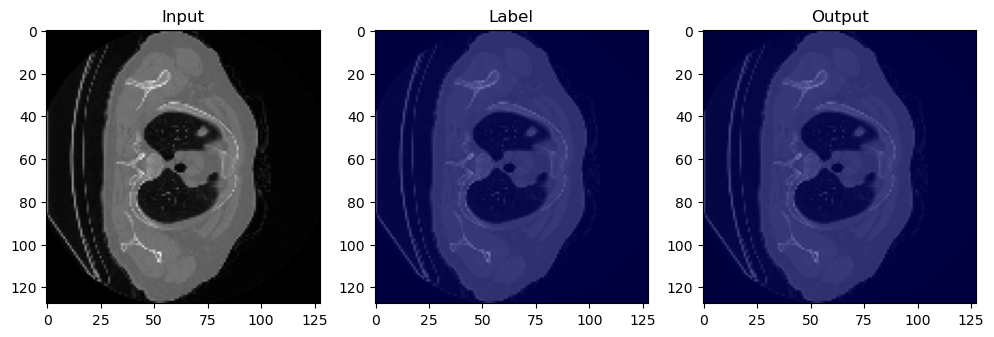

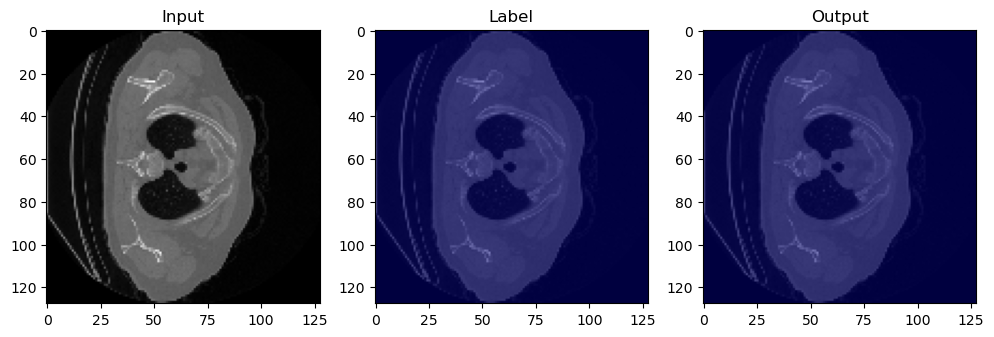

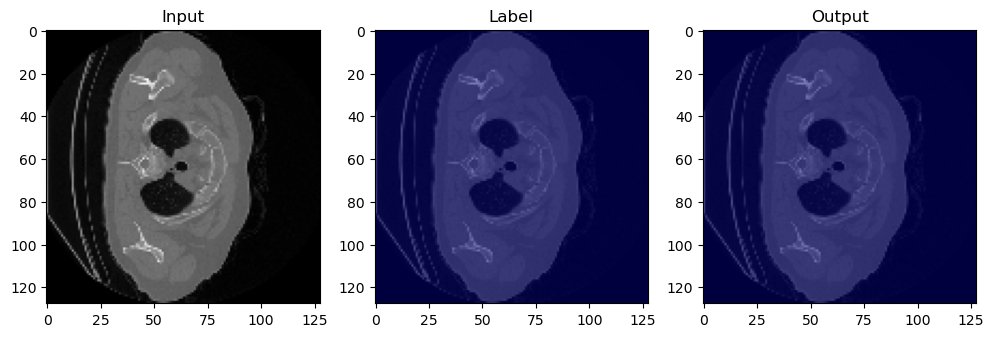

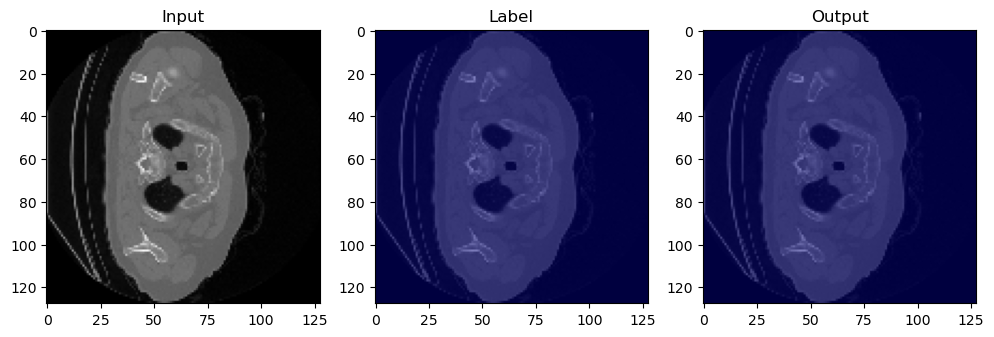

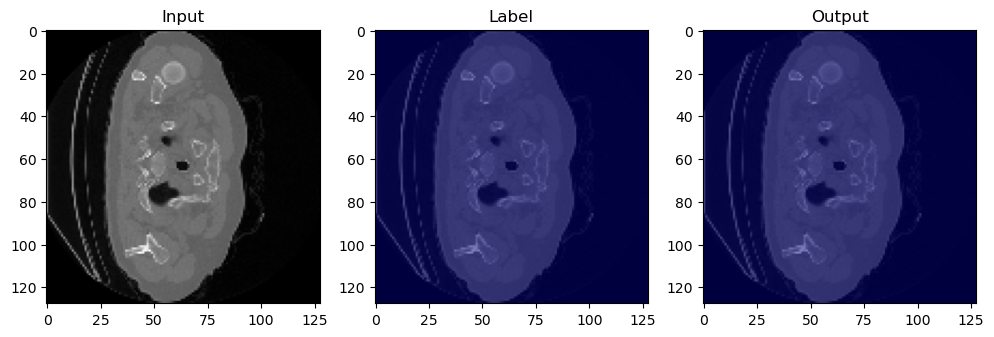

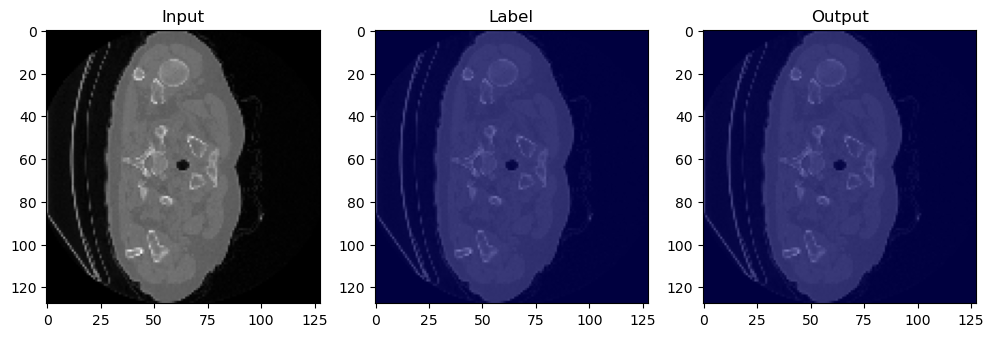

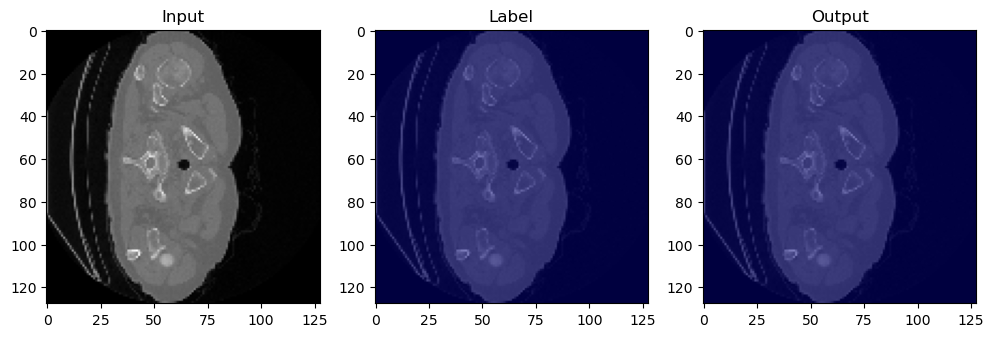

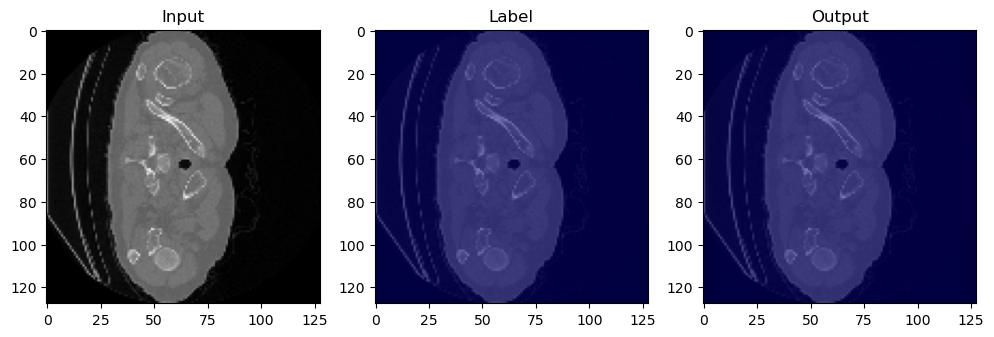

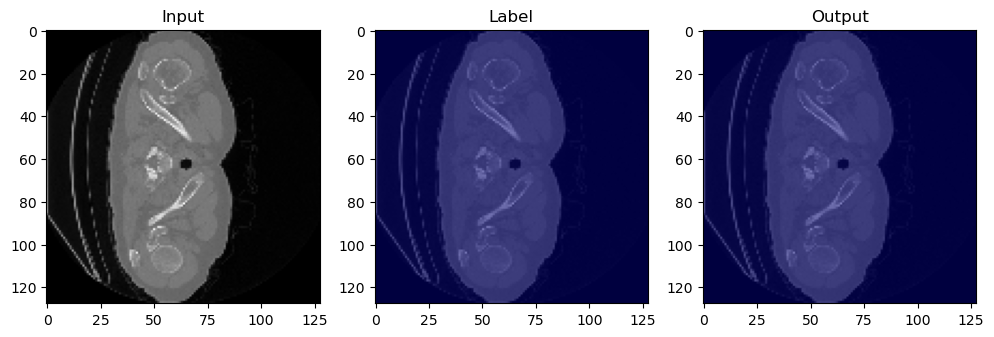

In [45]:
unetr_model.cpu()
swinunetr_model.cpu()

idx_val=1
for idx, val_data in enumerate(val_loader_without):
    if(idx==idx_val):
        checker_without = val_data
image_without, label_without = checker_without['image'], checker_without['label']

with torch.no_grad():
    unet_output = unet_model(image_without)
    unet_output = torch.nn.Softmax()(unet_output)
    unet_output = torch.round(unet_output)
    unet_output = unet_output[0, 0, :, :, :]
    
    unetr_output = unetr_model(image_without)
    unetr_output = torch.nn.Softmax()(unetr_output)
    unetr_output = torch.round(unetr_output)
    unetr_output = unetr_output[0, 0, :, :, :]
    
    swinunetr_output = swinunetr_model(image_without)
    swinunetr_output = torch.nn.Softmax()(swinunetr_output)
    swinunetr_output = torch.round(swinunetr_output)
    swinunetr_output = swinunetr_output[0, 0, :, :, :]
    
    #ensemble
    output = torch.stack([unet_output, unetr_output, swinunetr_output])
    output = torch.mean(output, dim=0, dtype=torch.float64)<0.5
    output = output.type(torch.int64)

    print(f"Output shape: {output.shape}")

    for slide in range(output.shape[2]):
        plt.figure("Test Model", (12, 12))

        plt.subplot(1, 3, 1)
        plt.title("Input")
        plt.imshow(image_without[0, 0, :, :, slide], cmap = "gray")

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(image_without[0, 0, :, :, slide], cmap = "gray")
        plt.imshow(label_without[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

        plt.subplot(1, 3, 3)
        plt.title("Output")
        plt.imshow(image_without[0, 0, :, :, slide], cmap = "gray")
        plt.imshow(output[:, :, slide], cmap = 'jet', alpha = 0.5)

        plt.show()